### `ising2d` Library Reference

The **`ising2d`** module provides a high-performance C++/CUDA implementation of the 2D Ising Model, exposed to Python via Pybind11.

#### 1. Initialization
Create a new simulation object.
* **`model = ising2d.IsingModel(L, T, J=1.0, h=0.0, seed=42)`**
    * `L`: Lattice side length (e.g., 1024 produces a $1024 \times 1024$ grid).
    * `T`: Temperature (Theoretical Critical Temp $T_c \approx 2.269$).
    * `J`: Interaction strength (default 1.0).
    * `h`: External magnetic field (default 0.0).
    * `seed`: Seed for the random number generator.

#### 2. Simulation & Physics
Evolve the system using the specified backend.
* **`model.update(mode, steps)`**
    * `steps`: Integer number of Monte Carlo steps.
    * `mode`: The backend execution strategy:
        * `ising2d.Mode.SERIAL`: Single-core CPU (Slowest, baseline).
        * `ising2d.Mode.OPENMP`: Multi-core CPU.
        * `ising2d.Mode.CUDA_GLOBAL`: GPU using Global Memory.
        * `ising2d.Mode.CUDA_SHARED`: GPU using Shared Memory (Fastest).
* **`model.set_T(T_new)`**
    * `T_new`: Update the temperature of an already existent object
* **`model.device_synchronize()`**
    * Blocks Python execution until the GPU has finished all queued tasks. Without this, timing code will be incorrect because CUDA launches kernels asynchronously.

#### 3. Data Access & Memory Management
Access simulation data without copying memory buffers.
* **`model.lattice`**
    * Returns a **NumPy View** of the live spin grid.
    * **Read/Write:** Modifying this array in Python instantly updates the C++ memory.
    * **Format:** 2D array of integers (`-1` or `+1`).
* **`model.magnetization(mode)`**
    * Returns the average magnetization per spin $\langle m \rangle$.
* **`model.energy(mode)`**
    * Returns the total energy of the system $E$.
* **`model.copy_to_host()`**
    * Copies the lattice from device to host.
* **`model.copy_to_device()`**
    * Copies the lattice from host to device.



#### 4. Performance Tuning
Adjust hardware parameters on the fly.
* **`model.set_cuda_block_size(size)`**
    * Sets the CUDA thread block dimension (Valid: 8, 16, 32).
* **`model.set_num_threads(n)`**
    * Sets the number of CPU threads used by the `OPENMP` mode.

## **HARDWARE SPECIFICATIONS**

The computational experiments were performed on a laptop workstation equipped with an **NVIDIA GeForce RTX 4050 Laptop GPU**.

Key specifications relevant to the performance analysis include:
* **CUDA Cores:** 2560 
* **Memory (VRAM):** 6 GB
* **Memory "Interface":** 96-bit bus width.
* **Memory Bandwidth:** Approximately 192 GB/s.
* **L2 Cache:** 12 MB.

More info can be found [here](https://www.techpowerup.com/gpu-specs/geforce-rtx-4050-mobile.c3953).

The **12 MB L2 Cache** size is a critical parameter for this study: it fully accommodates the lattice state for $L=512$ ($\approx 1$ MB), explaining the high cache hit rate and performance efficiency. However, for $L=2048$ ($\approx 16$ MB), the dataset exceeds the L2 capacity, forcing the system into a bandwidth-bound regime limited by the 96-bit memory bus.

In [1]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd
import seaborn as sns

# in order to load the ising2d library, we need to specify the
# project path and add it 
project_path = "/home/william/MCP_project/Ising2D_with_CUDA"
if project_path not in sys.path:
    sys.path.append(project_path)

import ising2d




# Physics verification

Before benchmarking computational performance, it is essential to validate that all implementations (Serial CPU, OpenMP, and CUDA) correctly reproduce the statistical mechanics of the 2D Ising model. This section verifies the physical consistency of the simulation through three key thermodynamic tests:

1. **Spontaneous Magnetization ($h=0$):** We analyze the Phase Transition plot to confirm the emergence of order below the critical temperature ($T_c \approx 2.27$). This test ensures the algorithm captures the fundamental symmetry breaking of the model.

2. **Equilibration Dynamics:** We examine the evolution of Energy vs. Simulation Steps to ensure the Metropolis algorithm correctly minimizes the system's energy and reaches a stable thermal equilibrium.

3. **Response to External Field:** We study the Phase Diagram ($h$ vs. $T$) to verify the alignment of spins under the influence of an external magnetic field, confirming the correct implementation of the interaction term $-h \sum \sigma_i$.

But, before that, we show an example of lattice visualization after a simulation ran until equilbrium:

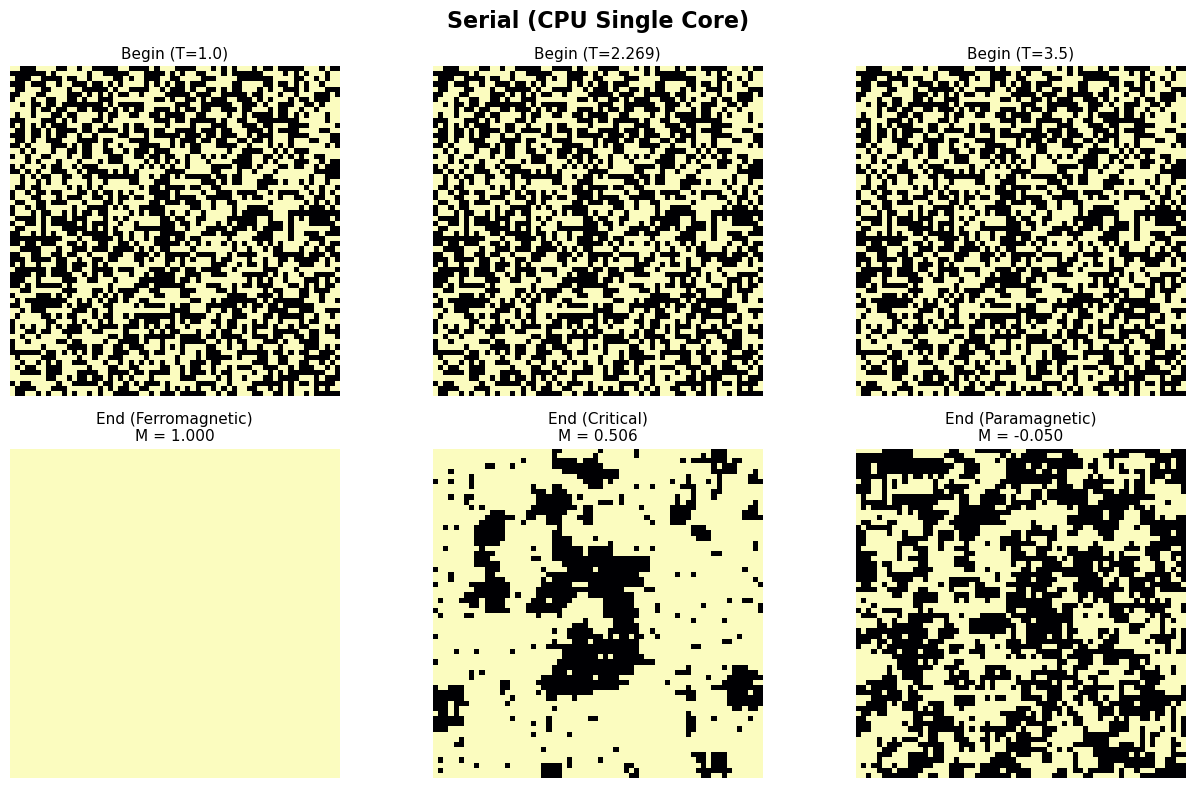

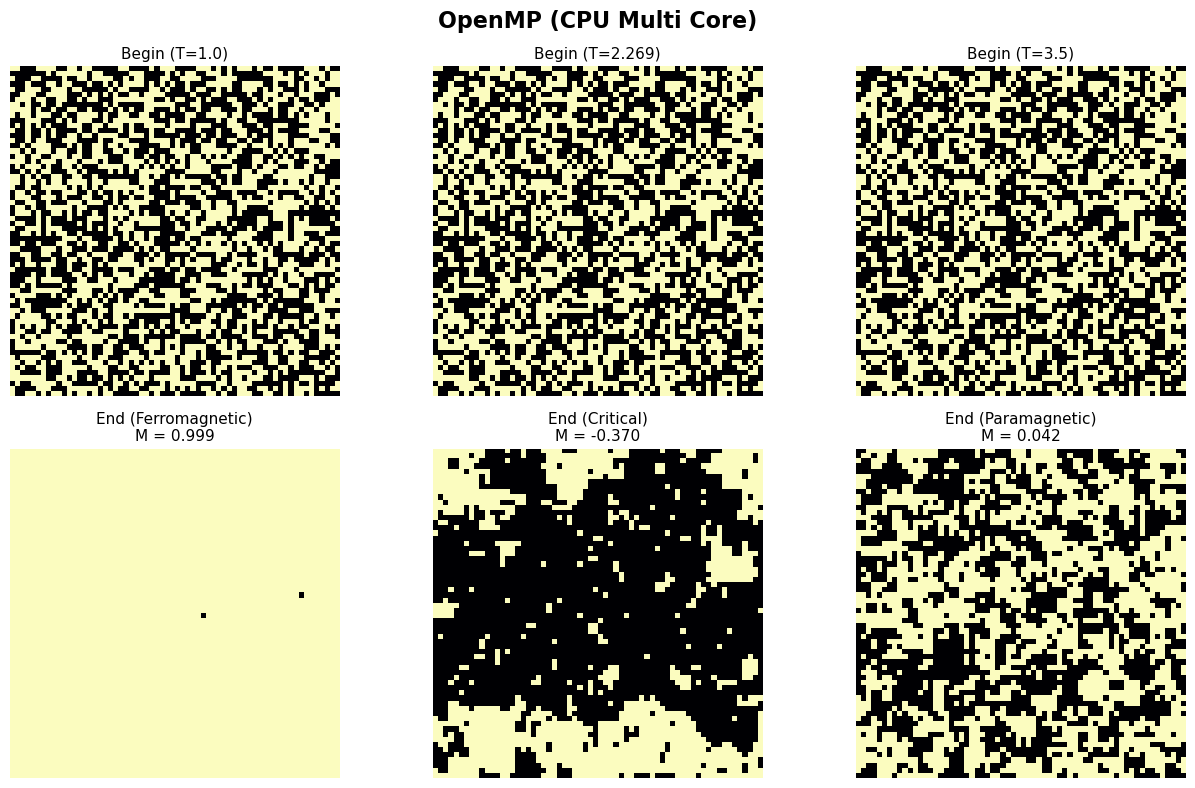

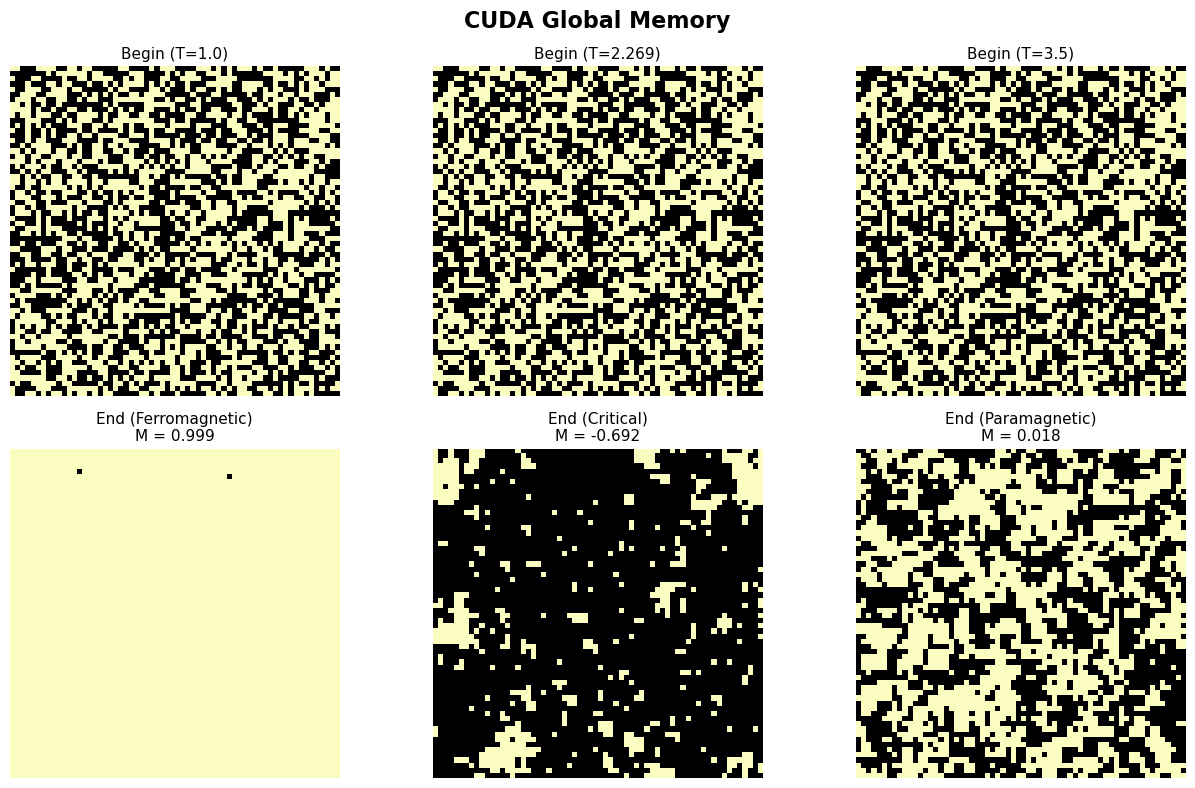

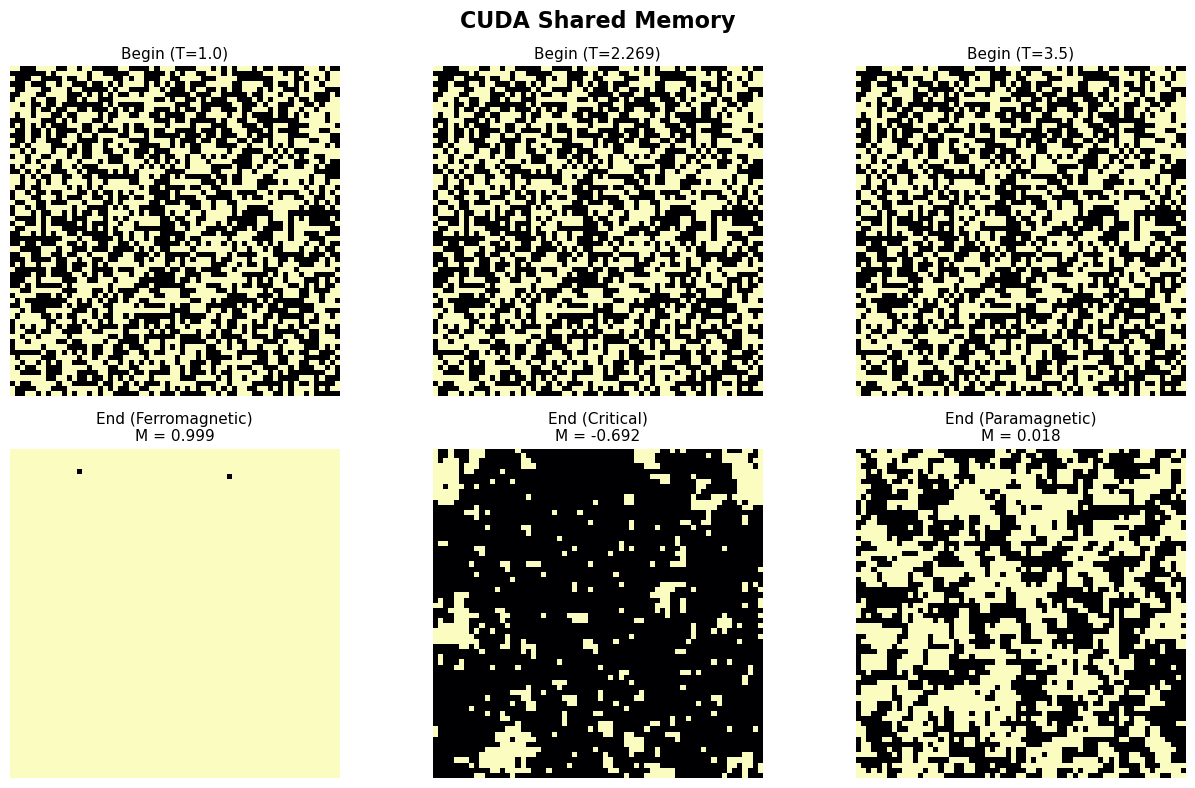

In [2]:
# Simulation data
L = 64          
steps = 20000   

modes = [
    (ising2d.Mode.SERIAL, "Serial (CPU Single Core)"),
    (ising2d.Mode.OPENMP, "OpenMP (CPU Multi Core)"),
    (ising2d.Mode.CUDA_GLOBAL, "CUDA Global Memory"),
    (ising2d.Mode.CUDA_SHARED, "CUDA Shared Memory")
]

# temperatures to scan
temps = [1.0, 2.269, 3.5]

for mode_enum, mode_title in modes:
    # 2 rows (Begin/End), 3 columns (Temps)
    fig, ax = plt.subplots(2, 3, figsize=(13, 8))
    fig.suptitle(f"{mode_title}", fontsize=16, fontweight='bold', y=0.98)
    
    for j, T in enumerate(temps):
        
        model = ising2d.IsingModel(L, T, seed=123)
        
        # Plot Beginning configuration (Row 0)
        ax[0, j].imshow(model.lattice, cmap='magma', vmin=-1, vmax=1)
        ax[0, j].set_title(f"Begin (T={T})", fontsize=11)
        ax[0, j].axis('off')
        
        # Run simulation
        if "CUDA" in mode_title:
            model.copy_to_device()

        model.update(mode_enum, steps)
        
        if "CUDA" in mode_title:
            # wait the blocks synchronization and copy the lattice to host
            model.device_synchronize()
            model.copy_to_host()

        # Plot End configuration (Row 1)
        ax[1, j].imshow(model.lattice, cmap='magma', vmin=-1, vmax=1)
        
        # Calculate statistics
        m = np.mean(model.lattice)
        
        # titles
        phase_name = "Ferromagnetic" if T < 2.0 else "Critical" if T < 3.0 else "Paramagnetic"
        ax[1, j].set_title(f"End ({phase_name})\nM = {m:.3f}", fontsize=11)
        ax[1, j].axis('off')
        
    plt.tight_layout()
    plt.show()

### 1. Spontaneous Magnetization ($h=0$)

In [3]:
T_values = np.linspace(0.1,4.5,15)
m_values = np.ndarray((T_values.shape[0],10))
L = 64

Running: Serial(CPU)


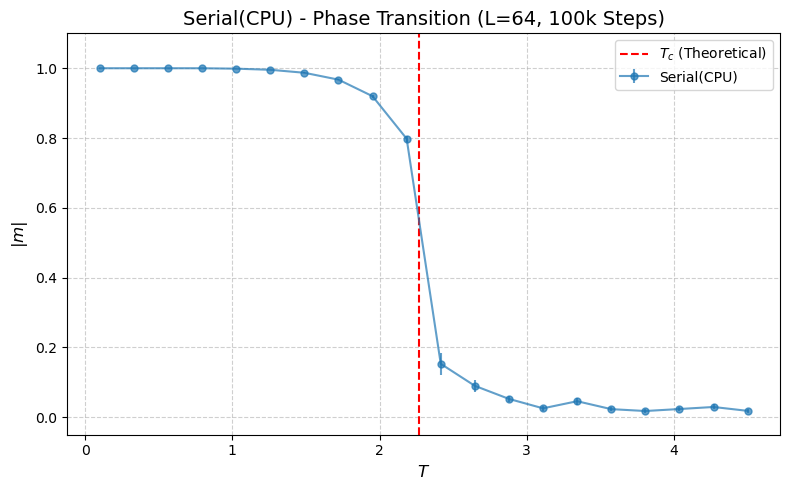

Running: OpenMP(Multi-Core)


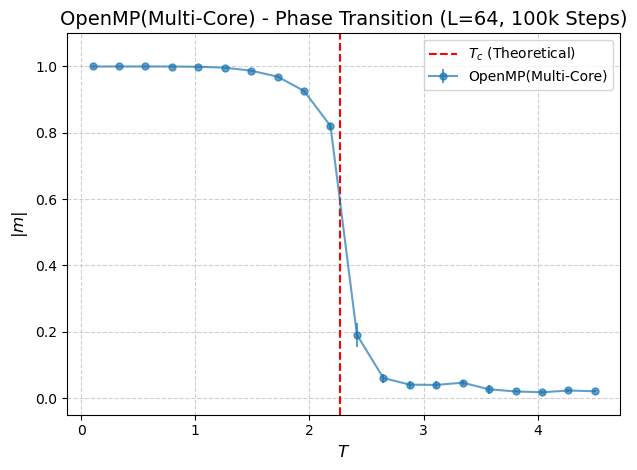

Running: CUDA(Global Mem)


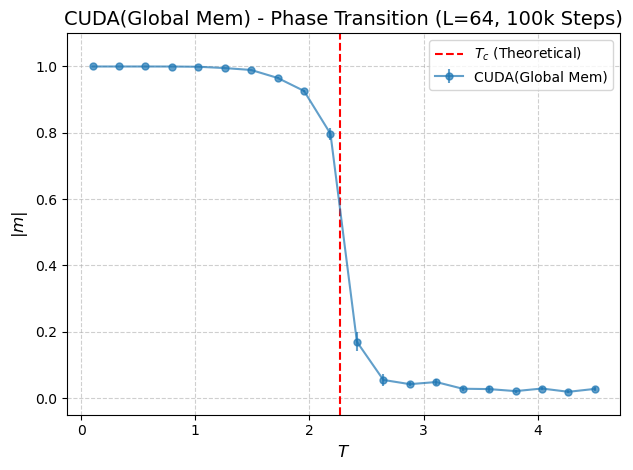

Running: CUDA(Shared Mem)


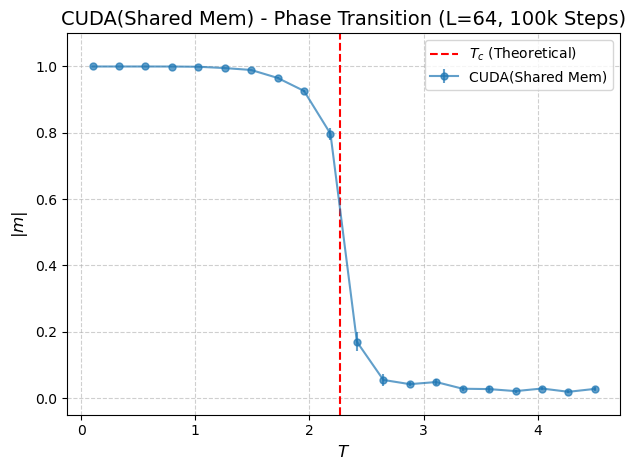

In [4]:
# initial data
L = 64 # lattice size
samples = 10 # number of measurements per temperature

# Temperature range: From 0.1 to 4.5
T_values = np.linspace(0.1, 4.5, 20)

# modest to test
modes = [
    ("Serial(CPU)", ising2d.Mode.SERIAL),
    ("OpenMP(Multi-Core)", ising2d.Mode.OPENMP),
    ("CUDA(Global Mem)", ising2d.Mode.CUDA_GLOBAL),
    ("CUDA(Shared Mem)", ising2d.Mode.CUDA_SHARED)
]

# initialize plot
plt.figure(figsize=(8, 5))

# loop over modes
for mode_name, mode_enum in modes:
    print(f"Running: {mode_name}")
    m_means = np.zeros_like(T_values)
    m_stds  = np.zeros_like(T_values)

    # loopr over temperatures
    for i in range(T_values.shape[0]):
        T = T_values[i]
        
        # Initialize the Model
        model = ising2d.IsingModel(L=L, T=T, seed=321 + i) # Vary seed slightly for randomness
        
        # explicitly set random -1/+1 spins (to avoid metastable states at low T)
        model.lattice[:, :] = np.random.choice([-1, 1], size=(L, L))
        
        # Memory Synchronization
        # we must copy it to the GPU if we are using a CUDA mode.
        if "CUDA" in mode_name:
            model.copy_to_device()
        
        # 100k steps --> allows the system to escape metastable states (domains)
        model.update(mode_enum, steps=100000)

        # We take multiple samples to compute the average and error
        measurements = np.zeros(samples)
        
        # Take the first measurement
        if "CUDA" in mode_name:
            model.device_synchronize()
            model.copy_to_host() # Update CPU RAM to read magnetization
        
        measurements[0] = model.magnetization()

        # Take remaining measurements with gaps
        for j in range(1, samples):
            model.update(mode_enum, steps=1000) # Decorrelate samples
            
            if "CUDA" in mode_name:
                model.device_synchronize()
                model.copy_to_host()
            
            measurements[j] = model.magnetization()

        # compute Statistics for this Temperature
        abs_m = np.abs(measurements)
        m_means[i] = abs_m.mean()
        m_stds[i]  = abs_m.std() / np.sqrt(samples)
    
    # Plotting the results for this mode
    plt.errorbar(T_values, m_means, yerr=m_stds, fmt='-o', markersize=5, label=f'{mode_name}', alpha=0.7)
    Tc = 2.269
    plt.axvline(x=Tc, color='red', linestyle='--', label=r'$T_c$ (Theoretical)')
    plt.title(f"{mode_name} - Phase Transition (L={L}, 100k Steps)", fontsize=14)
    plt.xlabel("$T$", fontsize=12)
    plt.ylabel("$|m|$", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.ylim(-0.05, 1.1)

    plt.tight_layout()
    plt.show()
    

### 2. Equilibration Dynamics

   -> Testing: Serial (CPU)
   -> Testing: OpenMP (Multi-Core)
   -> Testing: CUDA (Global Mem)
   -> Testing: CUDA (Shared Mem)


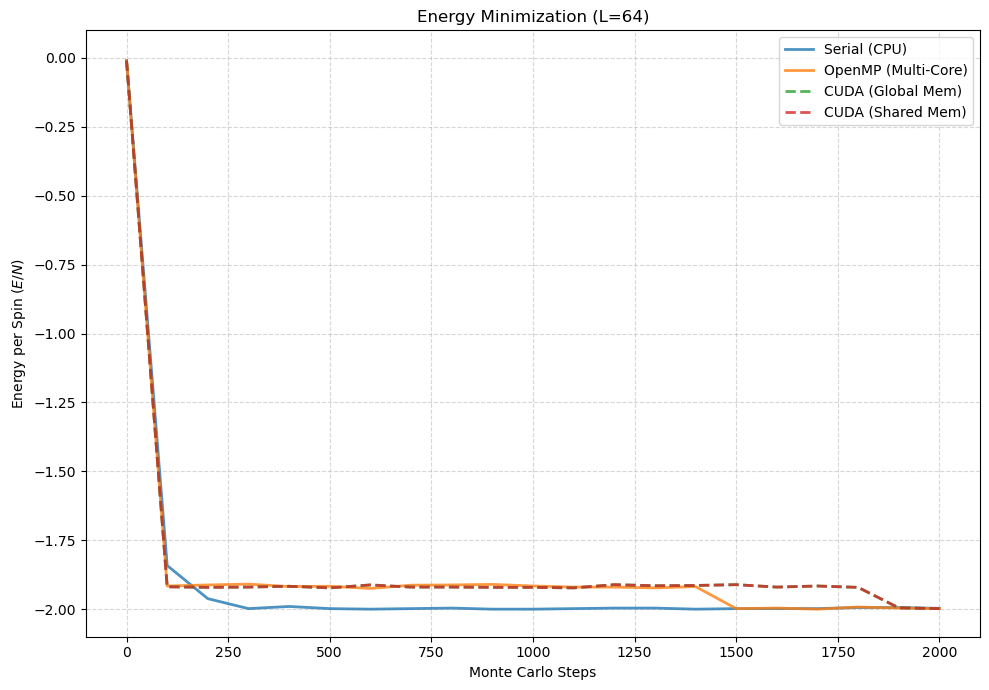

In [11]:
L = 64           
T = 1.0            
J = 1.0            
h = 0.0        
steps_total = 2000
measure_step = 100  

modes = [
    ("Serial (CPU)",      ising2d.Mode.SERIAL),
    ("OpenMP (Multi-Core)", ising2d.Mode.OPENMP),
    ("CUDA (Global Mem)", ising2d.Mode.CUDA_GLOBAL),
    ("CUDA (Shared Mem)", ising2d.Mode.CUDA_SHARED)
]

plt.figure(figsize=(10, 7))

for mode_name, mode_enum in modes:
    print(f"   -> Testing: {mode_name}")
    
    # Identical Initialization (Fixed seed for consistency)
    model = ising2d.IsingModel(L=L, T=T, J=J, h=h, seed=123)
    
    # If it is a GPU mode, load data to device
    if "CUDA" in mode_name:
        model.copy_to_device()
        
    # Lists for plotting
    energies = []
    steps_axis = []
    
    # Initial measurement
    if "CUDA" in mode_name: 
        # copy to host before measuring energy
        model.copy_to_host()
            
    energies.append(model.energy() / (L*L))
    steps_axis.append(0)
    
    # Evolution Loop
    for s in range(0, steps_total, measure_step):
        # Run steps
        model.update(mode_enum, measure_step)
        
        if "CUDA" in mode_name:
            model.device_synchronize()
            model.copy_to_host()
        
        # Measure
        E = model.energy() / (L*L)
        energies.append(E)
        steps_axis.append(s + measure_step)
        
    # Plot the curve for each algorithm
    linestyle = '--' if "CUDA" in mode_name else '-'
    plt.plot(steps_axis, energies, label=f"{mode_name}", linestyle=linestyle, alpha=0.8, linewidth=2)

plt.xlabel("Monte Carlo Steps")
plt.ylabel("Energy per Spin ($E/N$)")
plt.title(f"Energy Minimization (L={L})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(-2.1, 0.1)
plt.tight_layout()
plt.show()


### 3. Response to external field and phase diagram ($h$,T)

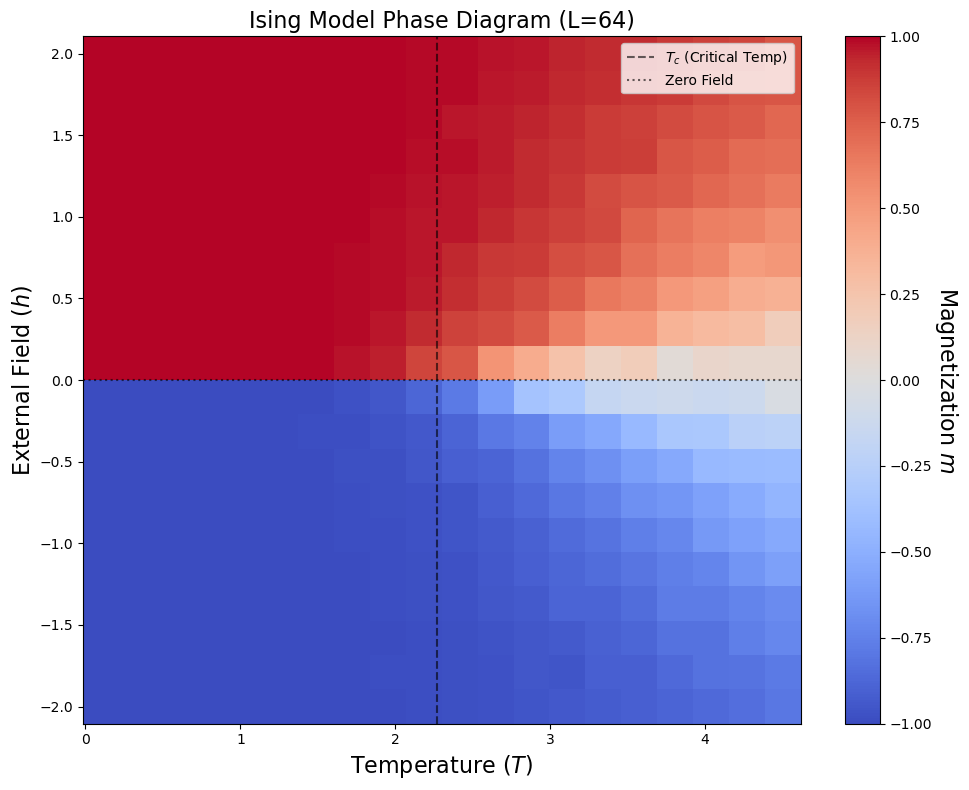

In [12]:
L = 64           
T = 1.0            
J = 1.0            
h = 0.0        
steps = 50_000
resolution = 20 # number of points in the heatmap

# Define ranges for T (x-axis) and h (y-axis)
T_values = np.linspace(0.1, 4.5, resolution)
h_values = np.linspace(-2.0, 2.0, resolution)
# grid to store magnetization results
M_grid = np.zeros((resolution, resolution))

for i, h in enumerate(h_values):
    for j, T in enumerate(T_values):
        model = ising2d.IsingModel(L, T, J = 1, h = h, seed=123 + i*j)
        
        # Cold Start: If h > 0, start all spins up. If h < 0, start all spins down.
        # This finds the global minimum quickly, without getting stuck in local minima of energy
        initial_spin = 1 if h >= 0 else -1
        model.lattice[:, :] = initial_spin
        
        # copy to GPU the new configuration
        model.copy_to_device()
        
        # Run until equilibrium. We use Cuda_Shared here to get faster results than serial
        # (benchmarks later)
        model.update(ising2d.Mode.CUDA_SHARED, steps)
        
        # Measure magnetization
        model.device_synchronize()
        model.copy_to_host()
        M_grid[i, j] = model.magnetization()

# plotting
plt.figure(figsize=(10, 8))

plt.pcolormesh(T_values, h_values, M_grid, cmap='coolwarm', vmin=-1, vmax=1, shading='auto')

# add Colorbar
cbar = plt.colorbar()
cbar.set_label("Magnetization $m$", rotation=270, labelpad=20, fontsize=16)

plt.title(f"Ising Model Phase Diagram (L={L})", fontsize=16)
plt.xlabel("Temperature ($T$)", fontsize=16)
plt.ylabel("External Field ($h$)", fontsize=16)

# theoretical markers
plt.axvline(2.269, color='black', linestyle='--', alpha=0.6, label='$T_c$ (Critical Temp)')
plt.axhline(0, color='black', linestyle=':', alpha=0.6, label='Zero Field')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Performance analysis

Having validated the physical accuracy of the simulation, we proceed to evaluate the computational efficiency of the four implementations: **Serial CPU**, **Parallel CPU (OpenMP)**, **CUDA Global Memory**, and **CUDA Shared Memory**.

To characterize the performance profile of each approach and identify the optimal hardware configurations, we conducted the following benchmarks:

1.  **OpenMP Scalability:** We vary the number of CPU threads to analyze the speedup behavior and identify the saturation point where thread management overhead outweighs parallel gains.
2.  **CUDA Kernel Tuning:** We test various block dimensions ($8\times8$, $16\times16$, $32\times32$) to determine the optimal grid configuration that maximizes GPU occupancy and minimizes memory latency.
3.  **Execution Time:** We measure the total runtime for a fixed number of steps to provide a direct comparison of "Time-to-Solution" across architectures.
4.  **Throughput Analysis:** We compute the **Spin Updates per Second**, a normalized metric that allows for a fair comparison of computational power independent of the total simulation duration.
5. **Asymptotic Scaling:** Log-scaling of execution time as a function of the system size.

### **IMPORTANT NOTE**

Kernel execution times were measured using high-resolution host-side timers with explicit cudaDeviceSynchronize() barriers to account for asynchronous CUDA launches. While this approach introduces a fixed launch overhead (due to the Python interpreter and driver latency), this effect is only significant for the smallest lattice size (L=64). For the computationally intensive regimes (L≥512), the kernel execution time dominates the total duration, rendering the measurement overhead negligible and ensuring the accuracy of the performance analysis.

### OpenMP - varying threads

In [13]:
L = 512 
T = 2.0            
J = 1.0            
h = 0.0        
steps_total = 1000
n_trials = 10

model = ising2d.IsingModel(L,T,J,h,123)
max_threads = 12

n_threads = np.arange(1,max_threads+1)          

In [15]:
times_measures = np.zeros(shape=(max_threads,n_trials))

for i,n_thread in enumerate(n_threads):
    for j in range(times_measures.shape[1]):
        #print(f"n_threads = {n_thread} | trial {j+1}", flush=True)
        model.set_num_threads(n_thread)
        
        start_time = time.perf_counter()
        model.update(ising2d.Mode.OPENMP,steps_total)
        end_time = time.perf_counter()

        times_measures[i][j] = end_time - start_time

avg_times = np.mean(times_measures,axis = 1)
std_times = np.std(times_measures, axis = 1)

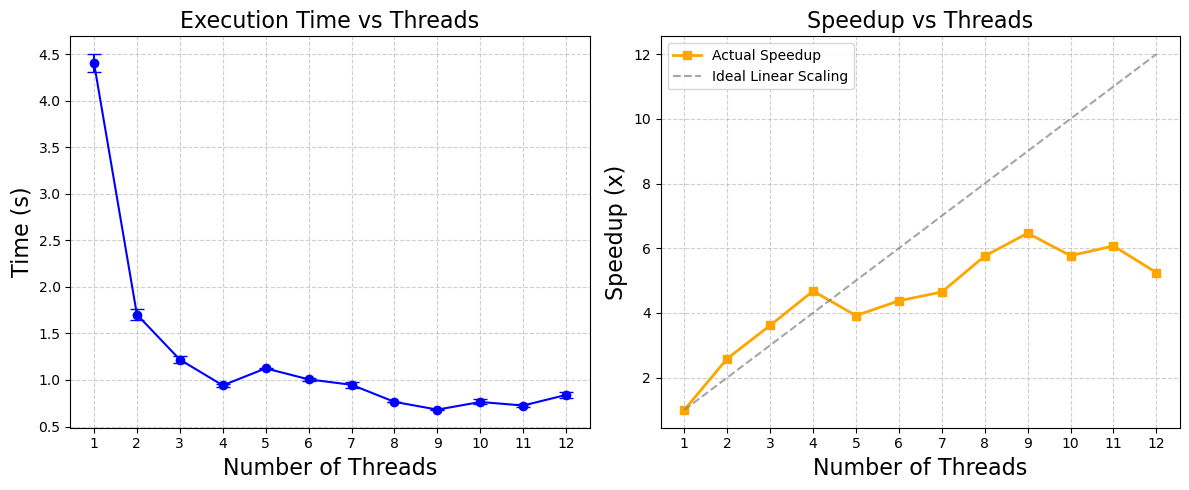

In [16]:
avg_times = np.mean(times_measures, axis=1)
std_times = np.std(times_measures, axis=1)/np.sqrt(n_trials)

# Speedup
speedup = avg_times[0] / avg_times
ideal_speedup = n_threads 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# time plot
ax1.errorbar(n_threads, avg_times, yerr=std_times, fmt='-o', color='blue', capsize=5, label='Measured Time')
ax1.set_title("Execution Time vs Threads", fontsize = 16)
ax1.set_xlabel("Number of Threads", fontsize = 16)
ax1.set_ylabel("Time (s)", fontsize = 16)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xticks(n_threads)

# speedup plot
ax2.plot(n_threads, speedup, '-s', color='orange', label='Actual Speedup', linewidth=2)
ax2.plot(n_threads, ideal_speedup, '--', color='gray', label='Ideal Linear Scaling', alpha=0.7)
ax2.set_title("Speedup vs Threads", fontsize = 16)
ax2.set_xlabel("Number of Threads", fontsize = 16)
ax2.set_ylabel("Speedup (x)", fontsize = 16)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xticks(n_threads)
ax2.legend()

plt.tight_layout()
plt.show()

The performance results reflect the hybrid architecture of the processor (Intel Core i5-13th Gen). The CPU features 4 Performance-cores (P-cores) and 4 Efficiency-cores (E-cores), resulting in 12 logical threads.

The scaling plot demonstrates a quasi-linear speedup up to 4 threads, corresponding to the saturation of the physical P-cores. Beyond 4 threads, the speedup curve deviates from linearity. This is expected behavior, as the scheduler begins utilizing the E-cores and/or the Hyper-Threading logical threads.

- E-cores operate at lower frequencies compared to P-cores.

- Hyper-Threading shares physical execution units, yielding diminishing returns compared to dedicated cores.

Consequently, for thread counts N>4, the load imbalance between heterogeneous cores (P vs E) and resource contention causes the efficiency per thread to drop, explaining the sub-linear scaling and the eventual plateau.

NOTE: The spike at n_threads = 12 is probably due to system's resources saturation, which causes context switching resulting in an increase in latency.

### CUDA - varying block size

In [ ]:
# data
L_values = [512, 2048]
block_sizes = [8, 16, 32]
steps_total = 5000
T, J, h = 1.0, 1.0, 0.0  

# warm-up phase to allow the GPU to reach stable clock speeds 
# and the to initialize resources.
n_warmup_trials = 5    # Discard first 5 trials (Transient state)
n_measure_trials = 5  # Keep the following 5 trials (Steady state)
total_trials = n_warmup_trials + n_measure_trials

# CUDA implementation modes to compare
modes = [ising2d.Mode.CUDA_GLOBAL, ising2d.Mode.CUDA_SHARED]
mode_names = ['Global Memory', 'Shared Memory']

data_records = []

for L in L_values:
    print(f"--> Benchmarking Lattice Size L = {L}")
    # Initialize the Ising Model
    model = ising2d.IsingModel(L, T, J, h, 123)

    for mode, key in zip(modes, mode_names):
        for bs in block_sizes:
            # Set the thread block dimensions (bs x bs)
            model.set_cuda_block_size(bs)
            
            # Initial kernel warm-up to ensure GPU is ready
            model.update(mode, steps=10)
            model.device_synchronize()

            for j in range(total_trials):
                # Synchronize device to ensure timing only covers current execution
                model.device_synchronize()
                
                start = time.perf_counter()
                model.update(mode, steps_total)
                # Essential: synchronize again to wait for asynchronous GPU kernels to finish
                model.device_synchronize()
                end = time.perf_counter()
                
                total_time = end - start
                
                # We only record measurements taken after the warm-up trials
                if j >= n_warmup_trials:
                    data_records.append({
                        "Lattice Size": f"L = {L}",
                        "Mode": key,
                        "Block Size": bs,
                        "Time (s)": total_time
                    })

# Create DataFrame for plotting
df = pd.DataFrame(data_records)


--> Benchmarking Lattice Size L = 512
--> Benchmarking Lattice Size L = 2048


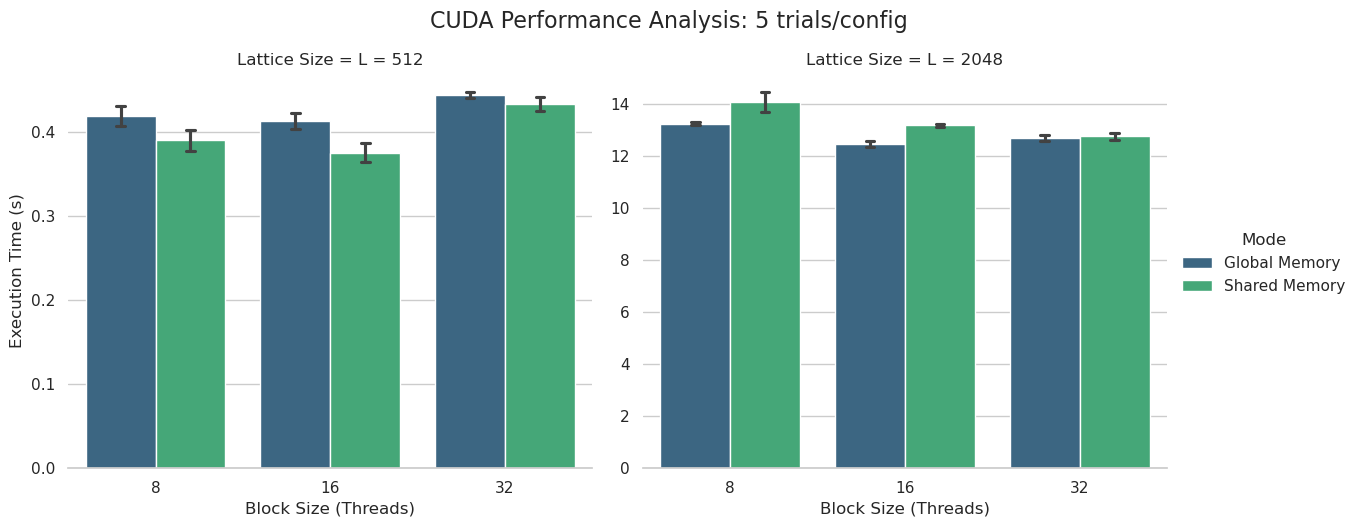

In [ ]:
# Plots
sns.set_theme(style="whitegrid")

# categorical plot to compare Global vs Shared memory performance
g = sns.catplot(
    data=df,
    kind="bar",
    x="Block Size",
    y="Time (s)",
    hue="Mode",
    col="Lattice Size",
    palette="viridis",
    height=5,
    aspect=1.2,
    capsize=0.1,
    errorbar="sd",  
    sharey=False    
)

g.figure.suptitle(f"CUDA Performance Analysis: {n_measure_trials} trials/config", y=1.05, fontsize=16)
g.set_axis_labels("Block Size (Threads)", "Execution Time (s)")
g.despine(left=True)

plt.show()

The comparative analysis of Global versus Shared memory implementations reveals two distinct operational regimes governed by the lattice size L:

- Latency-Hiding Regime (L=512): At this size, the dataset (≈1 MB) fits entirely within the GPU's L2 cache. The system is latency-bound. The Shared Memory implementation (Green) consistently outperforms the Global Memory version (Blue), particularly at block sizes 8 and 16. By explicitly loading tiles into the fast on-chip memory, the optimized kernel effectively reduces memory access latency and maximizes throughput.

- Bandwidth-Bound Regime (L≥512 (approximately)): As L increases, the performance gap disappears. The total data size (16 MB) exceeds the capacity of the L2 cache, forcing frequent "data exchange". In this regime, the simulation becomes bandwidth-bound, limited solely by the transfer rate of the VRAM. 

Note 1: The performance drop at Block Size 8 (L=2048) is mainly caused by the high volume of VRAM requests and halo overhead. Due to the low surface-to-volume ratio of small blocks, a disproportionate amount of memory bandwidth is wasted loading boundary data (ghost cells) relative to the actual spins being updated.

Note 2: At Block Size 32 (1024 threads) with L=512, performance is negatively impacted by a combination of low hardware occupancy (unused SM slots) and the high synchronization overhead inherent to the Shared Memory implementation. Large blocks increase the cost of "__syncthreads()", as the entire block must wait for the slowest thread.

### Time execution & spin updates per second

In [17]:
L_list = [64,128,256,512,1024]           
T = 2.0            
J = 1.0            
h = 0.0        
steps_total = 5000
n_trials = 5

modes = [ising2d.Mode.SERIAL, ising2d.Mode.OPENMP, ising2d.Mode.CUDA_GLOBAL, ising2d.Mode.CUDA_SHARED]
total_updates = np.array(np.array(L_list) * np.array(L_list) * steps_total).reshape(-1) #total spins updates in 1000 update steps

modes_times = {'Serial':[], 'OpenMP':[], 'Cuda(Global)':[],'Cuda(Shared)':[]}
spin_updates = {'Serial':[], 'OpenMP':[], 'Cuda(Global)':[],'Cuda(Shared)':[]}

for mode_enum, key in zip(modes, modes_times.keys()):
    print(f"Benchmarking {key}")
    
    for L,updates in zip(L_list,total_updates):
    
        model = ising2d.IsingModel(L, T, J, h, seed=123)
        # set openmp threads as 9 --> best performances
        model.set_num_threads(9)
        
        for i in range(n_trials):
            
            if 'Cuda' in key:
                model.device_synchronize()

            start_time = time.perf_counter()
            
            model.update(mode_enum, steps_total)
            
            if 'Cuda' in key:
                model.device_synchronize()
               
            end_time = time.perf_counter()

            total_time = end_time - start_time
            modes_times[key].append(total_time)

            # calculate spin updates per second
            updates_per_second = updates/total_time
            spin_updates[key].append(updates_per_second)

Benchmarking Serial
Benchmarking OpenMP
Benchmarking Cuda(Global)
Benchmarking Cuda(Shared)


In [18]:
data_for_plot = []

for key in modes_times.keys():
    # extract the lists
    times_list = modes_times[key]
    updates_list = spin_updates[key]
    idx = 0
    for L in L_list:
        for _ in range(n_trials):
            if idx < len(times_list):
                data_for_plot.append({'L': L, 'Time (s)': times_list[idx], 'Updates/sec':updates_list[idx],'Mode': key})
                idx += 1

df = pd.DataFrame(data_for_plot)

/tmp/ipykernel_11060/2267097264.py:22: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.barplot(data=df, y="Time (s)", ax=axes[0], **plot_kwargs)
/tmp/ipykernel_11060/2267097264.py:31: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.barplot(data=df, y="Updates/sec", ax=axes[1], **plot_kwargs)


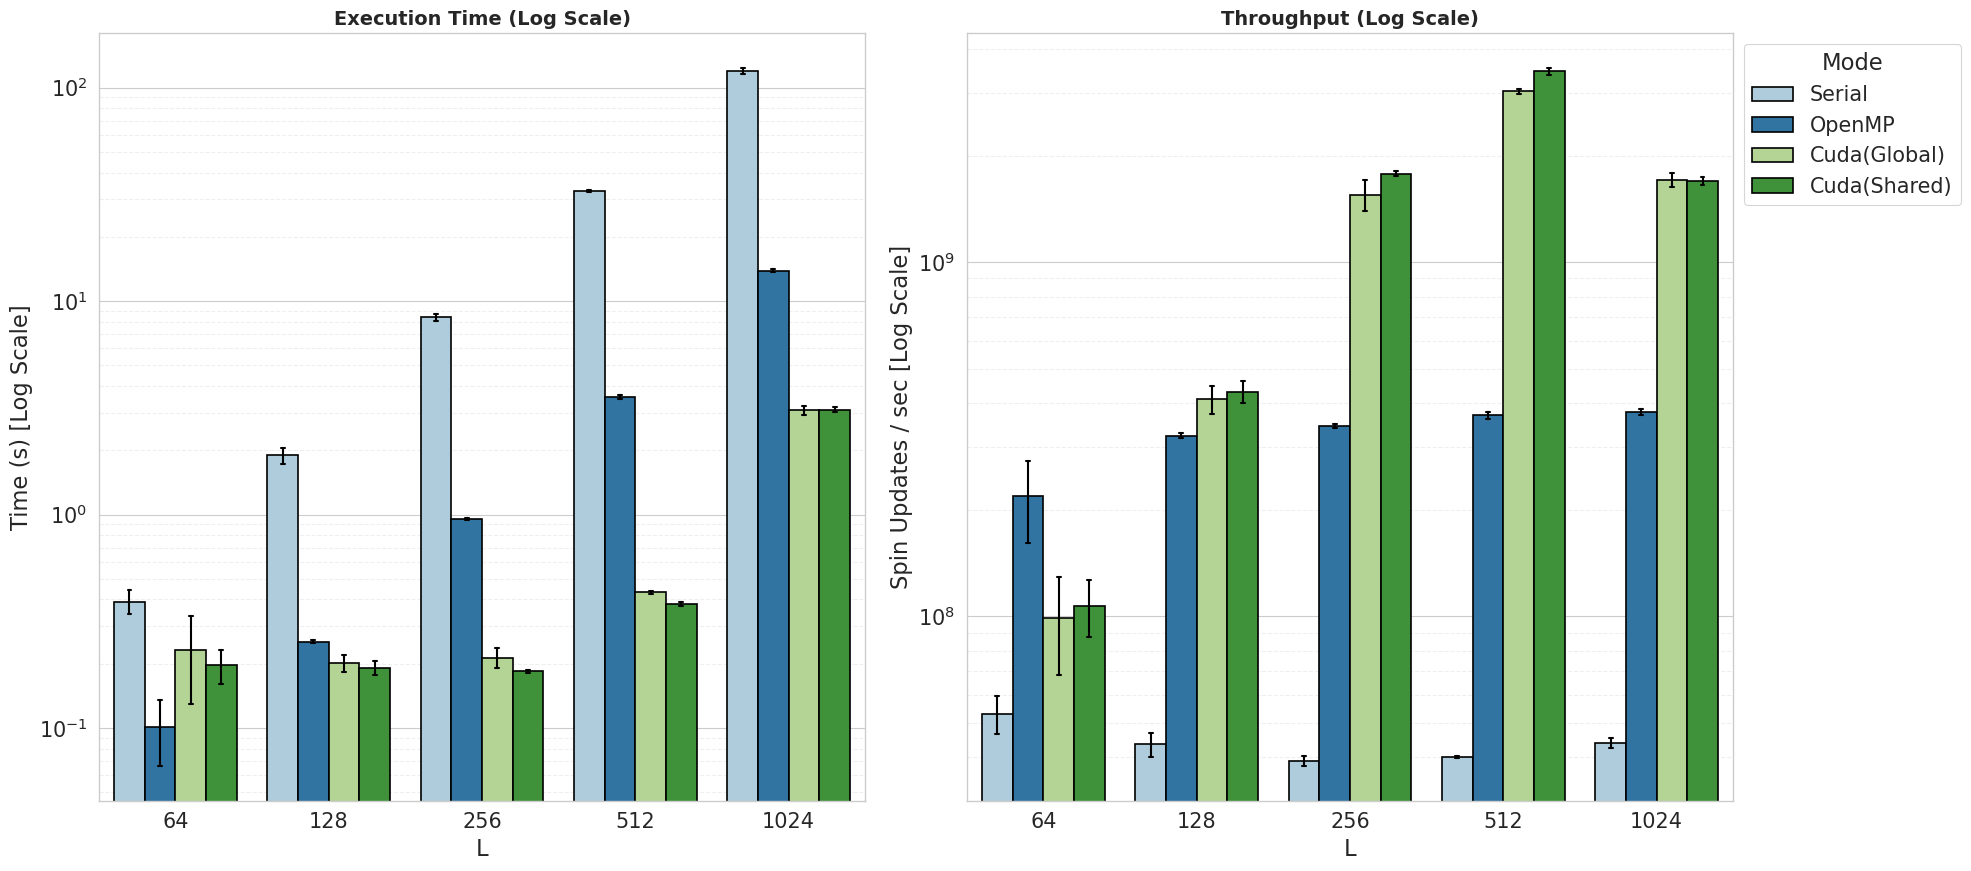

In [19]:
# Basic configurations
sns.set_theme(style="whitegrid", context="paper", font_scale=1.7)

custom_palette = sns.color_palette("Paired") 

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Common parameters
plot_kwargs = {
    'x': "L", 
    'hue': "Mode", 
    'palette': custom_palette,
    'edgecolor': "black",  
    'linewidth': 1.2,      
    'errorbar': "sd",      
    'capsize': 0.1,        
    'err_kws': {'linewidth': 1.5, 'color': 'black'} 
}

# Execution time plot 

sns.barplot(data=df, y="Time (s)", ax=axes[0], **plot_kwargs)

axes[0].set_title("Execution Time (Log Scale)", fontsize=14, fontweight='bold')
axes[0].set_yscale("log")  
axes[0].set_ylabel("Time (s) [Log Scale]")
axes[0].grid(True, which="minor", axis="y", linestyle="--", alpha=0.3)
axes[0].get_legend().remove() 

# Spin updates per second (i.e. throughput)
sns.barplot(data=df, y="Updates/sec", ax=axes[1], **plot_kwargs)

axes[1].set_title("Throughput (Log Scale)", fontsize=14, fontweight='bold')
axes[1].set_yscale("log")  
axes[1].set_ylabel("Spin Updates / sec [Log Scale]")
axes[1].grid(True, which="minor", axis="y", linestyle="--", alpha=0.3)

# Legend out from the plot
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1), title="Mode")

plt.tight_layout()
plt.show() 

While for L<512 the performance is limited by kernel launch overheads (latency-bound), at L=512 we observe the optimal hardware utilization. The slight performance dip at L=1024 indicates that the system has hit the 'memory wall,' where the lattice size exceeds the fast L2 cache capacity, leading to a bandwidth-limited regime.

### Log-scaling - time vs L

In [20]:
L_list_serial = [64,128,256]
L_list = [64, 128, 512, 1024, 2048, 4096]
T = 2.0            
J = 1.0            
h = 0.0        
steps_total = 5000
n_trials = 5

modes = [ising2d.Mode.SERIAL, ising2d.Mode.OPENMP, ising2d.Mode.CUDA_GLOBAL, ising2d.Mode.CUDA_SHARED]
modes_times = {'Serial':[], 'OpenMP':[], 'Cuda(Global)':[],'Cuda(Shared)':[]}

for mode_enum, key in zip(modes, modes_times.keys()):
    print(f"Benchmarking {key}")
    if (mode_enum == ising2d.Mode.SERIAL):
        for L in L_list_serial:
            model = ising2d.IsingModel(L, T, J, h, seed=123)
            for i in range(n_trials):
                
                start_time = time.perf_counter()
                model.update(mode_enum, steps_total)
                end_time = time.perf_counter()
                total_time = end_time - start_time
                
                modes_times[key].append(total_time)
    else:
        for L in L_list:
        
            model = ising2d.IsingModel(L, T, J, h, seed=123)
            # set openmp threads as 10 --> best performances
            model.set_num_threads(10)
            
            for i in range(n_trials):
                
                if 'Cuda' in key:
                    model.device_synchronize()

                start_time = time.perf_counter()
                
                model.update(mode_enum, steps_total)
                
                if 'Cuda' in key:
                    model.device_synchronize()
                
                end_time = time.perf_counter()

                total_time = end_time - start_time
                modes_times[key].append(total_time)

Benchmarking Serial
Benchmarking OpenMP
Benchmarking Cuda(Global)
Benchmarking Cuda(Shared)


In [21]:
modes_avg = {key: [] for key in modes_times.keys()}
modes_std = {key: [] for key in modes_times.keys()}

for key in modes_times.keys():
    data_matrix = np.array(modes_times[key]).reshape(-1, n_trials) # n_trials columns
    #print(data_matrix)
    #print("=======")
    #avg and std
    modes_avg[key] = np.mean(data_matrix, axis=1)
    #print(modes_avg[key])
    #print("===============")
    modes_std[key] = np.std(data_matrix, axis=1)

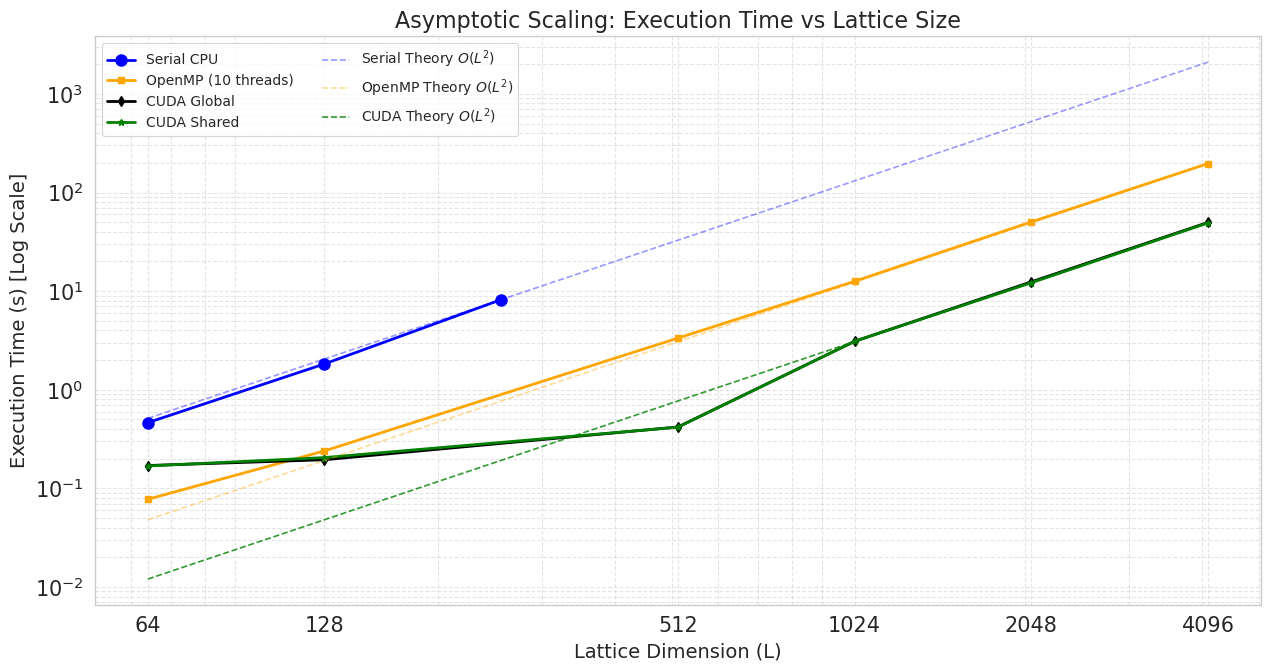

In [22]:
# Data Setup
L_serial = np.array([64, 128, 256])
L_parallel = np.array([64, 128, 512, 1024, 2048, 4096])

plt.figure(figsize=(13, 7))

# Plotting Experimental Data
plt.loglog(L_serial, modes_avg['Serial'], 'o-', label='Serial CPU', linewidth=2, markersize=8, color='blue')
plt.loglog(L_parallel, modes_avg['OpenMP'], 's-', label='OpenMP (10 threads)', linewidth=2, color='orange')
plt.loglog(L_parallel, modes_avg['Cuda(Global)'], 'd-', label='CUDA Global', linewidth=2, color='black')
plt.loglog(L_parallel, modes_avg['Cuda(Shared)'], '*-', label='CUDA Shared', linewidth=2, color='green')

# Plotting Theoretical Scaling Lines (Anchored to the last point of each series)
# Serial Theoretical
T_ref_ser = modes_avg['Serial'][-1]
L_ref_ser = L_serial[-1]
plt.loglog(L_parallel, T_ref_ser * (L_parallel / L_ref_ser)**2, '--', color='blue', alpha=0.4, label='Serial Theory $O(L^2)$')

# OpenMP Theoretical
T_ref_omp = modes_avg['OpenMP'][-1]
L_ref_omp = L_parallel[-1]
plt.loglog(L_parallel, T_ref_omp * (L_parallel / L_ref_omp)**2, '--', color='orange', alpha=0.4, label='OpenMP Theory $O(L^2)$')

# CUDA Shared Theoretical (Main Reference)
T_ref_cuda = modes_avg['Cuda(Shared)'][-1]
L_ref_cuda = L_parallel[-1]
plt.loglog(L_parallel, T_ref_cuda * (L_parallel / L_ref_cuda)**2, '--', color='green', alpha=0.8, label='CUDA Theory $O(L^2)$')

# Formatting
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlabel('Lattice Dimension (L)', fontsize=14)
plt.ylabel('Execution Time (s) [Log Scale]', fontsize=14)
plt.title('Asymptotic Scaling: Execution Time vs Lattice Size', fontsize=16)
plt.legend(fontsize=10, loc='upper left', ncol=2) # Two columns legend to save space
plt.xticks(L_parallel, L_parallel)

plt.tight_layout()
plt.show()

While the Serial and OpenMP implementations show nearly perfect agreement with the theoretical O($L^2$) scaling from the start, the GPU implementations (Global and Shared) exhibit an almost flat trend for smaller lattice sizes (L<512). In this regime, the system is "latency-bound": the GPU is under-utilized, and the execution time is dominated by fixed overheads, such as kernel launch latencies and driver synchronization. As L increases beyond 512, the GPU enters the "throughput-bound" regime, where the massive parallelism fully absorbs the computational load, finally aligning with the expected O($L^2$) asymptotic scaling.

### Overall speedup for L = 512

In [23]:
subset_means = df[df['L'] == 512].groupby('Mode')['Time (s)'].mean()

print(" Mean Execution Times (L=512) ")
print(subset_means)
print("\n--- Speedup Analysis (Reference: Serial) ")

t_serial      = subset_means['Serial']
t_openmp      = subset_means['OpenMP']
t_cuda_global = subset_means['Cuda(Global)']
t_cuda_shared = subset_means['Cuda(Shared)']

# speedup = Time Serial / Time Parallel
speedup_openmp = t_serial / t_openmp
speedup_global = t_serial / t_cuda_global
speedup_shared = t_serial / t_cuda_shared

print(f"OpenMP Speedup: {speedup_openmp:.2f}x")
print(f"CUDA (Global) Speedup: {speedup_global:.2f}x")
print(f"CUDA (Shared) Speedup: {speedup_shared:.2f}x")

# compare Shared vs Global directly
percent_improvement = ((t_cuda_global - t_cuda_shared) / t_cuda_global) * 100
print(f"\nShared Memory is {percent_improvement:.2f}% faster than Global Memory at L=1024")

 Mean Execution Times (L=512) 
Mode
Cuda(Global)     0.431450
Cuda(Shared)     0.379254
OpenMP           3.548335
Serial          32.774921
Name: Time (s), dtype: float64

--- Speedup Analysis (Reference: Serial) 
OpenMP Speedup: 9.24x
CUDA (Global) Speedup: 75.96x
CUDA (Shared) Speedup: 86.42x

Shared Memory is 12.10% faster than Global Memory at L=1024


# Extra: Simulated annealing

In [24]:
# data
resolution = 20 # points for each side of the heatmap
L = 32
T0 = 4.0
J, h = 1.0, 0.0

# Number of trials for each data point (statistical average)
n_trials = 3

# Alpha
alpha_values = np.linspace(1e-5, 5e-4, resolution) 
steps_values = np.linspace(100, 5000, resolution, dtype=int) 

# Grid to store the results
M_grid = np.zeros((resolution, resolution))

for i, alpha in enumerate(alpha_values):
    #print(f"================ ALPHA = {alpha} ================ \n")
    for k, max_steps in enumerate(steps_values):
        
        # Accumulator for the average
        total_mag = 0.0
        
        for trial in range(n_trials):
            # Re-initialize the model
            model = ising2d.IsingModel(L, T0, J, h, seed=123)
            model.set_num_threads(9)
            
            # Simulated Annealing Loop
            for t in range(max_steps):
                # Cooling schedule: T(t) = T0 * exp(-alpha * t)
                current_T = T0 * np.exp(-alpha * t)
                model.set_T(current_T)
                
                # Update the system
                # Using OpenMP mode here with relaxation steps
                model.update(ising2d.Mode.OPENMP, steps=1)
            
            # Add absolute magnetization to total
            total_mag += abs(model.magnetization())
        
        # Store the average in the grid
        M_grid[i, k] = total_mag / n_trials


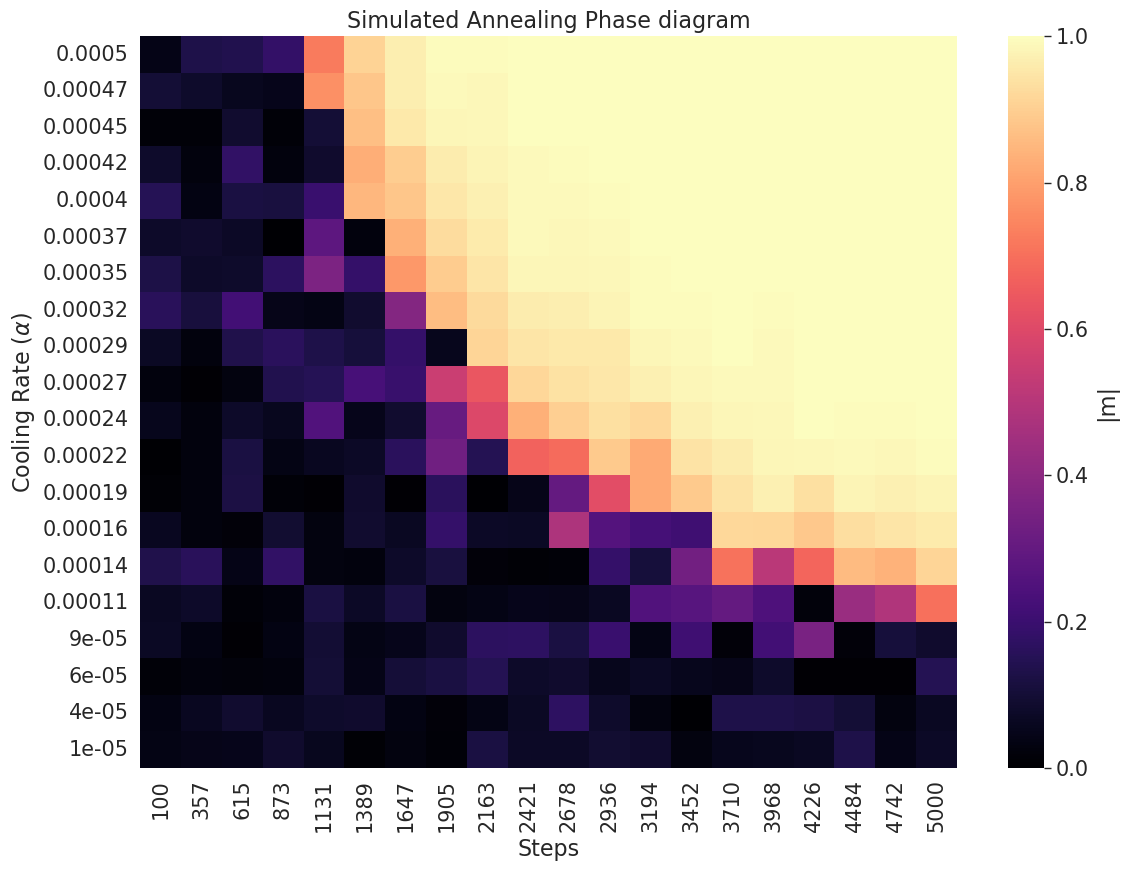

In [25]:
# Plots
plt.figure(figsize=(12, 9))

# Set labeles ticks
x_labels = np.round(steps_values, 0).astype(int)
y_labels = np.round(alpha_values, 5)

sns.heatmap(
    M_grid,
    xticklabels=x_labels, 
    yticklabels=y_labels,             
    cmap="magma",         
    cbar_kws={'label': '|m|'},
    vmin=0, vmax=1          # color scale between 0 and 1
)

plt.title("Simulated Annealing Phase diagram", fontsize = 16)
plt.xlabel("Steps", fontsize = 16)
plt.ylabel(r"Cooling Rate ($\alpha$)", fontsize = 16)

# invert the y-axis to get a 'cartesian' perspective
plt.gca().invert_yaxis() 

plt.tight_layout()
plt.show()

### Visual example

In [26]:
L = 128
steps = 5000
T_target = 1.0   
T_start = 4.0    

# model at fixed temperature
model_fixed = ising2d.IsingModel(L, T_target, seed=1234) 
model_fixed.set_num_threads(11)
model_fixed.update(ising2d.Mode.OPENMP, steps)


# model with simulated annealing
# We initialize at High T and cool down in a loop
model_sa = ising2d.IsingModel(L, T_start, seed=123)
model_sa.set_num_threads(8)

# Calculate alpha to reach T \approx 1.0 by the end
# T_final = T_start * exp(-alpha * steps)  -> alpha = -ln(T_final/T_start) / steps
alpha = -np.log(T_target / T_start) / steps 

for t in range(steps):
    current_T = T_start * np.exp(-alpha * t)
    model_sa.set_T(current_T)
    model_sa.update(ising2d.Mode.OPENMP, steps=1)

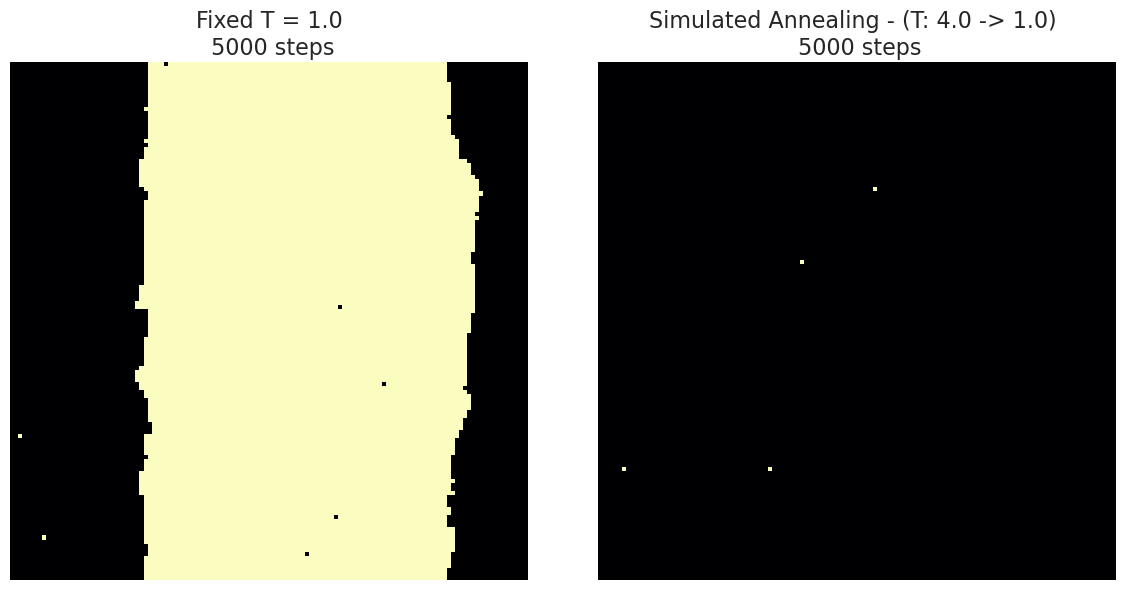

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Fixed T
axes[0].imshow(model_fixed.lattice, cmap='magma', vmin=-1, vmax=1)
axes[0].set_title(f"Fixed T = {T_target}\n {steps} steps", fontsize = 16)
axes[0].axis('off')

# Plot 2: Simulated Annealing
axes[1].imshow(model_sa.lattice, cmap='magma', vmin=-1, vmax=1)
axes[1].set_title(f"Simulated Annealing - (T: {T_start} -> 1.0) \n {steps} steps", fontsize = 16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Ultimately, Simulated Annealing acts as a robust global optimization method for the 2D Ising model. Unlike the Metropolis quench, which often becomes trapped in metastable states (local energy minima) due to the formation of domain walls, the annealing protocol provides sufficient thermal energy to overcome these barriers. This allows the system to explore the phase space more effectively and converge to the true ferromagnetic ground state.